In [288]:
import pandas as pd
import numpy as np
import torch
from torch import nn

In [289]:
train_data=pd.read_csv('data/train.csv')
test_data=pd.read_csv('data/test.csv')
train_data.shape

(1460, 81)

In [290]:
train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]]

,Id,MSSubClass,MSZoning,LotFrontage,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,WD,Normal,208500
1,2,20,RL,80.0,WD,Normal,181500
2,3,60,RL,68.0,WD,Normal,223500
3,4,70,RL,60.0,WD,Abnorml,140000


In [291]:
all_features=pd.concat([train_data.iloc[:,1:-1],test_data.iloc[:,1:-1]])
all_features.shape

(2919, 79)

In [292]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [293]:
all_features[numeric_features]=all_features[numeric_features].apply(lambda x:(x-x.mean()/x.std()))
all_features[numeric_features] =all_features[numeric_features].fillna(0)

In [294]:
all_features=pd.get_dummies(all_features,dummy_na=True)
all_features.shape

(2919, 331)

In [295]:
num_train=train_data.shape[0]
train_features=torch.tensor(all_features[:num_train].values,dtype=torch.float)
test_features=torch.tensor(all_features[num_train:].values,dtype=torch.float)
train_labels=torch.tensor(train_data.SalePrice.values,dtype=torch.float).view(-1,1)

In [296]:
loss=nn.MSELoss()
def get_net(feature_num):
    net=nn.Linear(feature_num,1)
    for param in net.parameters():
        nn.init.normal_(param,mean=0,std=0.01)
    return  net

In [297]:
def log_rmse(net,features,labels):
    with torch.no_grad():
        clipped_preds=torch.max(net(features),torch.tensor(1.0))
        rmse=torch.sqrt(loss(clipped_preds.log(),labels.log()))
    return rmse.item()

In [298]:
from matplotlib import pyplot as plt


def semilogy(x_val,y_val,x_label,y_label,x2_value=None,y2_value=None,legend=None,figsize=(3.5,2.5)):
    plt.figure(figsize=figsize)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.semilogy(x_val,y_val)
    if x2_value and y2_value:
        plt.semilogy(x2_value,y2_value)
        plt.show()

In [299]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls,test_ls=[],[]
    dataset=torch.utils.data.TensorDataset(train_features,train_labels)
    train_iter=torch.utils.data.DataLoader(dataset,batch_size,shuffle=True)
    optim=torch.optim.Adam(net.parameters(),lr=learning_rate,weight_decay=weight_decay)
    net=net.float()
    for epoch in range(num_epochs):
        for x,y in train_iter:
            l=loss(net(x.float()),y.float())
            optim.zero_grad()
            l.backward()
            optim.step()
        train_ls.append(log_rmse(net,train_features,train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

In [300]:
def get_k_fold_data(k,i,x,y):
    fold_size=x.shape[0]//k
    x_train,y_train=None,None
    for j in range(k):
        idx = slice(j*fold_size,(j+1)*fold_size)
        x_part, y_part = x[idx, :], y[idx]
        if j == i:
            x_valid, y_valid = x_part, y_part
        elif x_train is None:
            x_train, y_train = x_part, y_part
        else:
            x_train = torch.cat((x_train, x_part), dim=0)
            y_train = torch.cat((y_train, y_part), dim=0)
    return x_train, y_train, x_valid, y_valid

In [301]:
def k_fold(k, x_train, y_train, num_epochs,
           learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, x_train, y_train)
        net=get_net(x_train.shape[1])
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse',
                         range(1, num_epochs + 1), valid_ls,
                         ['train', 'valid'])
        print('fold %d, train rmse %f, valid rmse %f' % (i, train_ls[-1], valid_ls[-1]))
    return train_l_sum / k, valid_l_sum / k

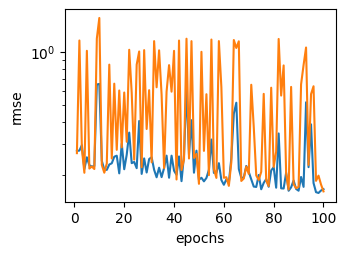

fold 0, train rmse 0.165745, valid rmse 0.160931
fold 1, train rmse 0.174259, valid rmse 0.191160
fold 2, train rmse 0.150905, valid rmse 0.166771


(0.163636381427447, 0.1729541023572286)

In [302]:
k_fold(3,train_features,train_labels,100,5,0,64)

train rmse 0.214875


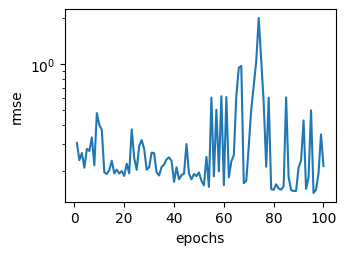

In [303]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net(train_features.shape[1])
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse')
    print('train rmse %f' % train_ls[-1])
    preds = net(test_features).detach().numpy()
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('./submission.csv', index=False)
train_and_pred(train_features, test_features, train_labels, test_data, num_epochs, lr, weight_decay, batch_size)
